<a href="https://colab.research.google.com/github/minmaxHong/PyTorch-Basic-Syntax/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구현 순서
1. 이미지 업로드 & 전처리
2. 모델 구현
3. 이미지 훈련 (훈련이미지 & 검증 이미지)
4. 이미지 테스트
5. 모델 평가

In [28]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
import torch.nn as nn

from torch.nn.modules.normalization import LocalResponseNorm # LRN
from torch.utils.data import random_split # split train / valid
from torch import optim


In [29]:
# Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)

if device == 'cuda':
  torch.cuda.manual_seed(777)


In [30]:
# cifar10 Loading

cifar_train = dsets.CIFAR10(root = '/data',
                            train = True,
                            transform = transforms.ToTensor(),
                            download = True)

cifar_test = dsets.CIFAR10(root = '/data',
                             train = False,
                             transform = transforms.ToTensor(),
                             download = True)

Files already downloaded and verified
Files already downloaded and verified


# 이미지 전처리 과정

Train data
* 1. 256 * 256 down sample
* 2. 227 * 227 center crop
* 3. Do horizontal flip of 227 * 227 center crop image
* 4. subtract the mean activity over the training set from each pixel (normalization)


Test data
* 1. 227 * 227 center crop
* 2. Normalize

In [31]:
# mean, std
import numpy as np

meanRGB = [np.mean(x.numpy(), axis = (1, 2)) for x, _ in cifar_train] # criterion by row, column --> become RGB mean
stdRGB = [np.std(x.numpy(), axis = (1, 2)) for x, _ in cifar_train]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)

print(stdR, stdG, stdB)

0.49139965 0.48215845 0.4465309
0.20220213 0.19931543 0.20086348


In [32]:
# Image Transform

train_tf = transforms.Compose([
    transforms.Resize((256, 256)), # 256 * 256 down sample
    transforms.CenterCrop((227, 227)), # 227 * 227 center crop
    transforms.RandomHorizontalFlip(p = 1), # Horizontal Flip
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]) # Normalize(z-score)
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227)),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

cifar_train.transform = train_tf
cifar_test.transform = test_tf

2732
images indices:  2732


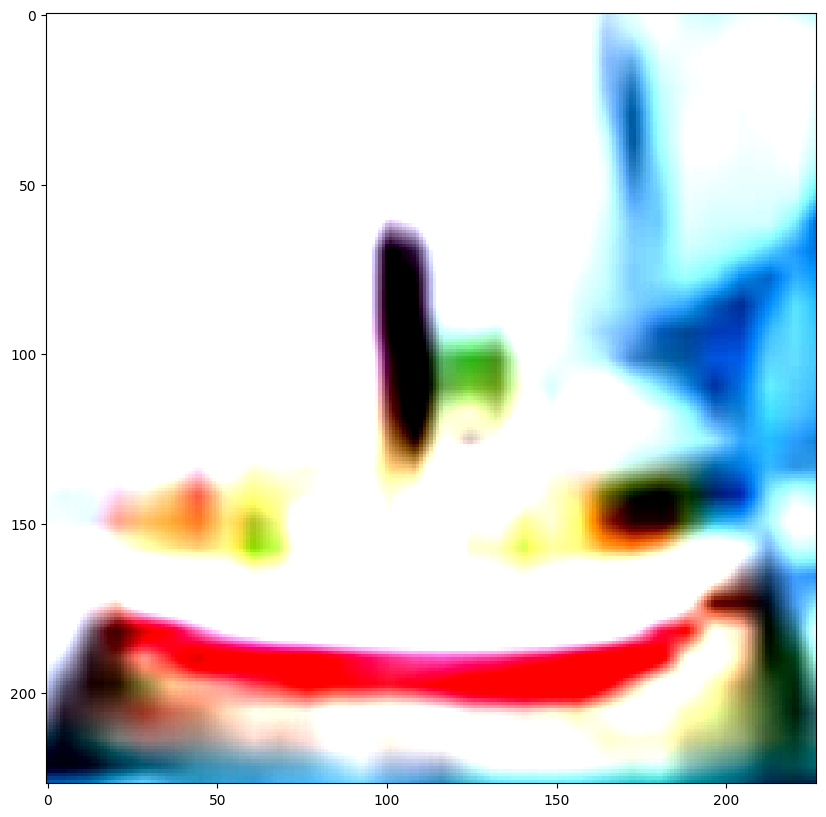

In [33]:
import torch
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# display the transformed sample images from train_ds

# define helper function to show images
def show(img, y=None, color=True):

    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

# pick a random sample image
rnd_inds = int(np.random.randint(0, len(cifar_train), 1))
print(rnd_inds)
img, label = cifar_train[rnd_inds]
print('images indices: ', rnd_inds)

plt.figure(figsize=(10, 10))
show(img)

# Model 구현
* The paper says the image is 224*224, but that's a typo.
* Maxpool : Conv 1, 2, 5 layer
* LRN : Conv 1, 2 layer
* ReLU : All Layer


## initialized weight
* 1.mean : 0, std : 0.01 (weight)
* 2.bias : 2,4,5 conv, All Fc  initialized constant 1

In [34]:
class Alexnet(nn.Module):
  def __init__(self):
    super(Alexnet, self).__init__()

    # input size : 3 * 227 * 227

    # Conv Layer
    self.conv = nn.Sequential(

        # Layer 1
        nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 11, stride = 4, padding = 0),
        nn.ReLU(),
        nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75, k = 2),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        # Layer 2
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # (b x 256 x 27 x 27)
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # Layer 3
        nn.Conv2d(256, 384, 3, 1, 1),
        nn.ReLU(),

        # Layer 4
        nn.Conv2d(384, 384, 3, 1, 1),
        nn.ReLU(),

        # Layer 5
        nn.Conv2d(384, 256, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )

    self.fc = nn.Sequential(

        # Fc 1
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),

        # Fc 2
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p = 0.5),

        # Cifar10, label : 0~9
        nn.Linear(4096, 10)

    )
  # weight initialized

  # 2, 4, 5 conv layer, Fc layer --> constant 1
  def init_weight(self):

    for layer in self.conv:
      if isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean = 0, std = 0.01)
        nn.init.constant_(layer.bias, 0)

      nn.init.constant_(self.conv[4].bias, 1)
      nn.init.constant_(self.conv[10].bias, 1)
      nn.init.constant_(self.conv[12].bias, 1)


    for layer in self.fc:
      if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean = 0, std = 0.01)
        nn.init.constant_(layer.bias, 1)


  # model sequence
  def forward(self, x):
    out = self.conv(x)

    # flatten
    out = out.view(out.size(0), -1)
    out = self.fc(out)

    return out

In [9]:
model = Alexnet().to(device)

torchsummary.summary(model, input_size = (3, 227, 227), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [10]:
# verify initialized weight

print(model.state_dict())


OrderedDict([('conv.0.weight', tensor([[[[ 2.8156e-02, -4.3199e-02, -3.8627e-02,  ...,  1.3889e-02,
           -1.5862e-02, -1.0317e-02],
          [-5.0143e-02, -3.4761e-02, -2.1636e-02,  ...,  1.9064e-02,
            4.3584e-02, -1.0802e-02],
          [ 3.9276e-02, -8.4599e-03,  5.5538e-03,  ...,  4.5348e-02,
           -3.4021e-02, -2.4161e-02],
          ...,
          [-3.1088e-02,  1.9241e-02,  2.6543e-02,  ...,  1.0985e-02,
           -4.0944e-02, -3.0223e-02],
          [ 4.9377e-02,  3.5366e-02, -2.2885e-02,  ..., -2.8920e-03,
            7.8806e-03, -2.1495e-02],
          [ 3.1144e-02, -3.1940e-02,  4.7625e-02,  ...,  1.2448e-02,
            2.0597e-02,  3.1439e-03]],

         [[-2.5610e-02,  2.4836e-02, -5.0348e-02,  ..., -1.1165e-02,
            1.1219e-02, -3.4193e-02],
          [-2.6936e-03,  3.7572e-02, -5.3956e-03,  ...,  3.3332e-02,
            4.9831e-02, -3.7959e-03],
          [-4.7150e-02, -2.4883e-02,  3.5738e-02,  ..., -1.0646e-02,
            2.8784e-02,  2.

# 3. 훈련 & 검증

* 1.Use SGD
* 2.batch_size = 128
* 3.momentum = 0.9
* 4.weight decay = 0.0005
* 5.learning_rate = 0.01
* 6.epoch : 90

In [11]:
batch_size = 128
learning_rate = 0.01
epoch = 15 # for real, epoch = 90
momentum = 0.9
weight_decay = 0.0005

In [12]:
# split train, valid

# cifar train : 50,000


train_ratio = 0.8
val_ratio = 0.2

train_size = int(len(cifar_train) * train_ratio)
val_size = len(cifar_train) - train_size

cifar_split_train, val_split_train = random_split(cifar_train, [train_size, val_size])

cifar_split_train

In [13]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)
criterion = nn.CrossEntropyLoss().to(device)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = cifar_split_train,
                                           batch_size=  batch_size,
                                           shuffle = True,
                                           drop_last = True)

val_loader = torch.utils.data.DataLoader(dataset = val_split_train,
                                        batch_size = batch_size,
                                        shuffle = True,
                                        drop_last = True)

In [15]:
total_batch = len(train_loader) # 40000(전체 훈련데이터) / 128(batch_size) --> 312번의 가중치 업데이트

# 코드설명

model_train()
* Dropout, Batch Normalization을 잘 수행하기 위함.
* model_train()을 수행하면, Dropout층이 활성화되어 랜덤한 뉴런을 비활성화 시킨다.
* model_train()을 수행하면, BatchNormalization 층이 학습 모드로 설정되어 학습 데이터의 통계량을 사용하여 정규화를 수행한다.


In [16]:
# Step 4: 반복적인 학습
for epoch in range(epoch):
    model.train()  # 모델을 학습 모드로 설정


    '''
    1. for문 1번 반복할때마다 batch_idx는 batch_size만큼 증가
     ex) 1 iter: 0 ~ 127
         2 iter: 128 ~ 255

         전체 훈련 데이터를 다 쓰기전까지 반복.
    '''
    for batch_idx, (data, target) in enumerate(train_loader):
        # 데이터와 레이블을 GPU로 이동 (if available)
        data, target = data.to(device), target.to(device)

        # Forward 연산
        output = model(data)

        # 손실 계산
        loss = criterion(output, target)

        # Backward 연산 및 매개변수 업데이트
        optimizer.zero_grad() # 미분값 중복 방지
        loss.backward() # 오차역전파
        optimizer.step() # parameter 업데이트

        # 일정 간격으로 손실 출력


        if batch_idx % 100 == 0:
            #print(len(train_loader)) 항상 312로 동일한 값
            print(batch_idx)
            print('Epoch {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) # 100.은 실수형을 말한다.(실수형으로 출력하기 위함)
                # len(train_loader)는 배치 개수를 나타낸다. 여기서는 312개(312번 가중치 update)

    # 검증 데이터셋을 사용한 모델 평가
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0

    # 미분값 계산 x
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            # Forward 계산
            output = model(data)

            val_loss += criterion(output, target).item() # 손실함수 계산
            pred = output.argmax(dim=1, keepdim=True) # 예측값(행마다)에서 가장 큰 값의 인덱스 가져옴, (n, 1)형식
            correct += pred.eq(target.view_as(pred)).sum().item() # target을 pred와 같은 shape으로 만들어준다.
            '''
            .eq()는 두 tensor의 shape이 동일해야 비교 연산이 가능하다.
            '''

    val_loss /= len(val_loader.dataset) # 검증 손실함수
    val_accuracy = 100. * correct / len(val_loader.dataset) # 검증 정확도

    # 검증 결과 출력
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), val_accuracy))

0
Epoch 1 [0/40000 (0%)]	Loss: 2.302081
100
Epoch 1 [12800/40000 (32%)]	Loss: 2.302513
200
Epoch 1 [25600/40000 (64%)]	Loss: 2.276784
300
Epoch 1 [38400/40000 (96%)]	Loss: 1.971884

Validation set: Average loss: 0.0155, Accuracy: 2606/10000 (26.06%)

0
Epoch 2 [0/40000 (0%)]	Loss: 2.020010
100
Epoch 2 [12800/40000 (32%)]	Loss: 1.859806
200
Epoch 2 [25600/40000 (64%)]	Loss: 1.706688
300
Epoch 2 [38400/40000 (96%)]	Loss: 1.618534

Validation set: Average loss: 0.0120, Accuracy: 4318/10000 (43.18%)

0
Epoch 3 [0/40000 (0%)]	Loss: 1.500437
100
Epoch 3 [12800/40000 (32%)]	Loss: 1.545638
200
Epoch 3 [25600/40000 (64%)]	Loss: 1.437235
300
Epoch 3 [38400/40000 (96%)]	Loss: 1.321374

Validation set: Average loss: 0.0098, Accuracy: 5406/10000 (54.06%)

0
Epoch 4 [0/40000 (0%)]	Loss: 1.361312
100
Epoch 4 [12800/40000 (32%)]	Loss: 1.160246
200
Epoch 4 [25600/40000 (64%)]	Loss: 1.080000
300
Epoch 4 [38400/40000 (96%)]	Loss: 1.206527

Validation set: Average loss: 0.0091, Accuracy: 5895/10000 (58.95

# 모델 테스트


In [22]:
cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False)

In [41]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in cifar_test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1) # 가장 높은값의 인덱스, 값 반환 --> 여기서는 가장 높은 값만 반환했다.

    total += labels.size(0) # 전체 데이터 예측 개수(len(cifar_test_loader) 와 같다)
    correct += (predicted == labels.to(torch.long)).sum().item() # predicted, labels의 텐서 타입이 일치하지 않아서 long으로 바꾸어줌.
    # 맞으면 correct에 true, 틀리면 false 반환한다. 맞은 것만 개수 센다.

accuracy = 100 * correct / total
print(f'Accuracy : {accuracy}')


Accuracy : 79.15
